In [105]:
%pip install kagglehub
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import kagglehub

path = kagglehub.dataset_download("jehanbhathena/weather-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/weather-dataset


In [106]:
import glob


path_imgs = list(glob.glob(path+'/dataset'+'/**/*.jpg'))

In [107]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,/kaggle/input/weather-dataset/dataset/rime/535...,rime
1,/kaggle/input/weather-dataset/dataset/glaze/66...,glaze
2,/kaggle/input/weather-dataset/dataset/rainbow/...,rainbow
3,/kaggle/input/weather-dataset/dataset/glaze/66...,glaze
4,/kaggle/input/weather-dataset/dataset/rainbow/...,rainbow


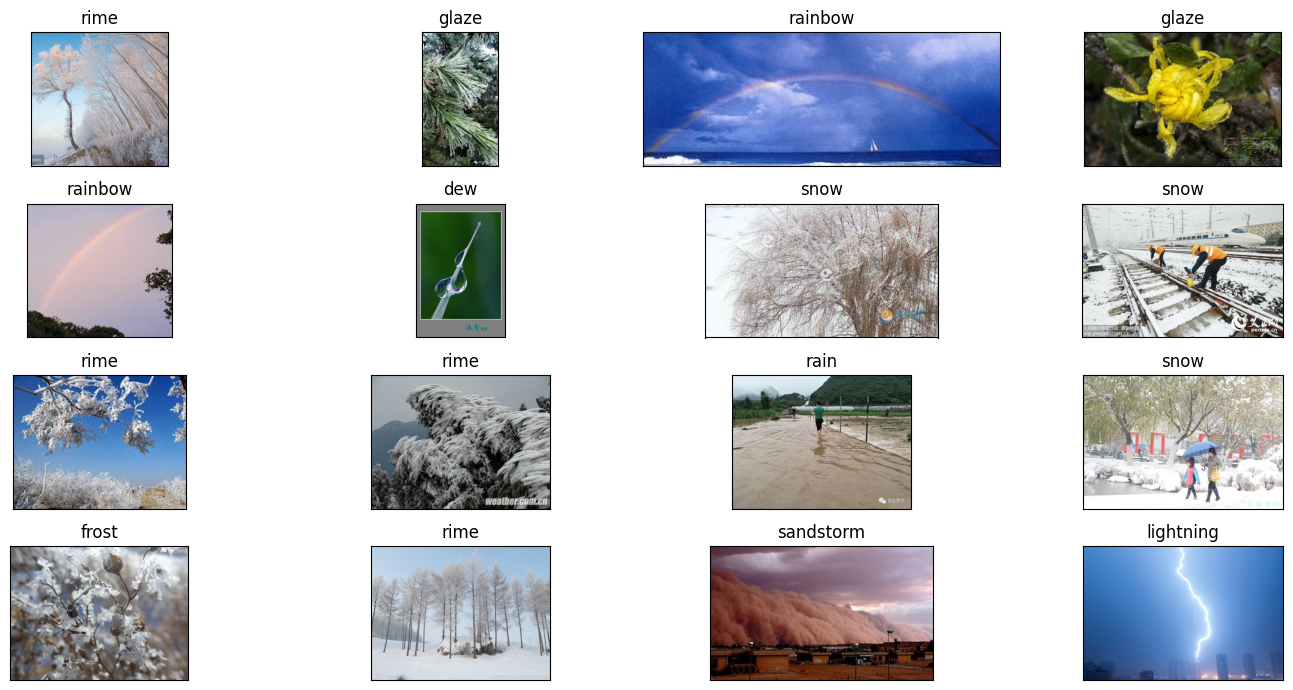

In [108]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

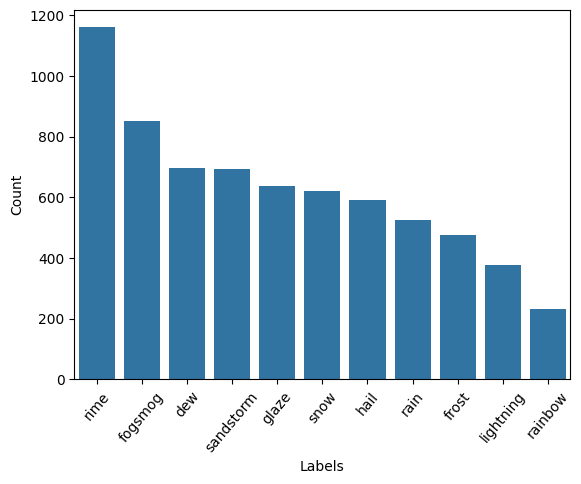

In [109]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [110]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

In [111]:
VALIDATION_SPLIT = 0.2
N_TRAIN = len(train_df)
N_VALIDATION = N_TRAIN * VALIDATION_SPLIT
BATCH_SIZE = 20
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [112]:
import tensorflow as tf

In [113]:
initial_learning_rate = 0.0001
decay_steps = STEPS_PER_EPOCH * 50
decay_rate = 0.96
staircase = False

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=staircase
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [114]:
import os

def get_callbacks(name = "default"):
  checkpoint_path = "training/" + name + "/checkpoint.weights.h5"

  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)
  return [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, mode='min'), cp_callback]

In [115]:
from tensorflow.keras import regularizers

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(11, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [116]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_388 (Conv2D)             │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_376         │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_389 (Conv2D)             │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_377         │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_390 (Conv2D)             │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_378         │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,040,203 (72.63 MB)

 Trainable params: 19,039,755 (72.63 MB)

 Non-trainable params: 448 (1.75 KB)

In [117]:
from tensorflow.keras.optimizers import Adam, RMSprop

model.compile(optimizer=get_optimizer(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [118]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='File_Path',
    y_col='Labels',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    target_size=(150, 150)
)
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='File_Path',
    y_col='Labels',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    target_size=(150, 150)
)

Found 5489 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.


In [119]:
history = model.fit(
      train_generator,
      epochs=15,
      validation_data=validation_generator,
      verbose=2,
      callbacks = get_callbacks())

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15

Epoch 1: saving model to training/default/checkpoint.weights.h5
275/275 - 46s - 168ms/step - accuracy: 0.5404 - loss: 3.2591 - val_accuracy: 0.2360 - val_loss: 5.6643
Epoch 2/15

Epoch 2: saving model to training/default/checkpoint.weights.h5
275/275 - 72s - 262ms/step - accuracy: 0.6764 - loss: 2.1926 - val_accuracy: 0.6657 - val_loss: 2.1920
Epoch 3/15

Epoch 3: saving model to training/default/checkpoint.weights.h5
275/275 - 30s - 110ms/step - accuracy: 0.7318 - loss: 1.9695 - val_accuracy: 0.6759 - val_loss: 2.1530
Epoch 4/15

Epoch 4: saving model to training/default/checkpoint.weights.h5
275/275 - 42s - 151ms/step - accuracy: 0.7905 - loss: 1.7731 - val_accuracy: 0.7451 - val_loss: 1.9124
Epoch 5/15

Epoch 5: saving model to training/default/checkpoint.weights.h5
275/275 - 31s - 111ms/step - accuracy: 0.8379 - loss: 1.5885 - val_accuracy: 0.7254 - val_loss: 2.0600
Epoch 6/15

Epoch 6: saving model to training/default/checkpoint.weights.h5
275/275 - 31s - 113ms/step - 

Text(0.5, 1.0, 'Training and validation loss')

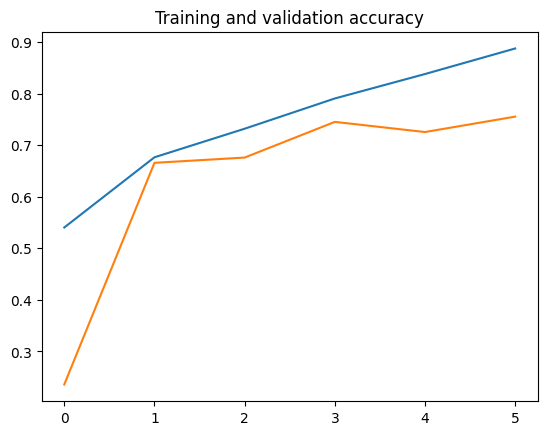

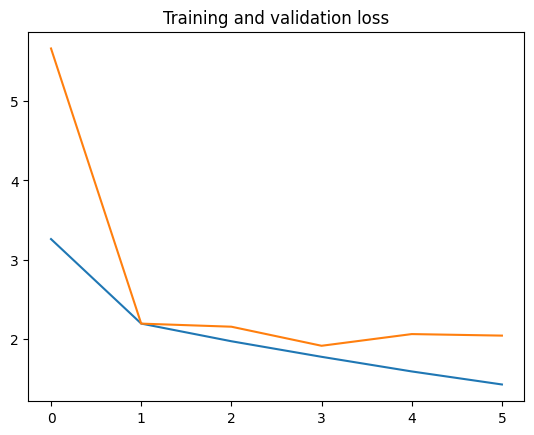

In [120]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

Found 5489 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 56s 206ms/step - accuracy: 0.5931 - loss: 2.4829 - val_accuracy: 0.6905 - val_loss: 1.9831
Epoch 2/15
  1/274 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.6500 - loss: 1.9327

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6500 - loss: 1.9327 - val_accuracy: 0.6824 - val_loss: 1.9994
Epoch 3/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 56s 204ms/step - accuracy: 0.6445 - loss: 2.1815 - val_accuracy: 0.6672 - val_loss: 2.2094
Epoch 4/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7500 - loss: 1.6128 - val_accuracy: 0.6613 - val_loss: 2.2404
Epoch 5/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 56s 203ms/step - accuracy: 0.6414 - loss: 2.1800 - val_accuracy: 0.6919 - val_loss: 2.0210
Epoch 6/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7500 - loss: 2.3256 - val_accuracy: 0.6926 - val_loss: 2.0002
Epoch 7/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 77s 203ms/step - accuracy: 0.6715 - loss: 2.0552 - val_accuracy: 0.7036 - val_loss: 2.0064
Epoch 8/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6000 - loss: 2.1364 - val_accuracy: 0.6941 - val_loss: 2.0296
Epoch 9/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 76s 202ms/step - accuracy: 0.6802 - loss: 2.0010 - val_accurac

Text(0.5, 1.0, 'Training and validation loss')

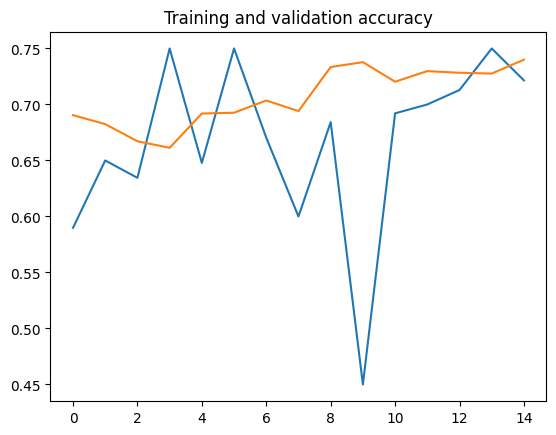

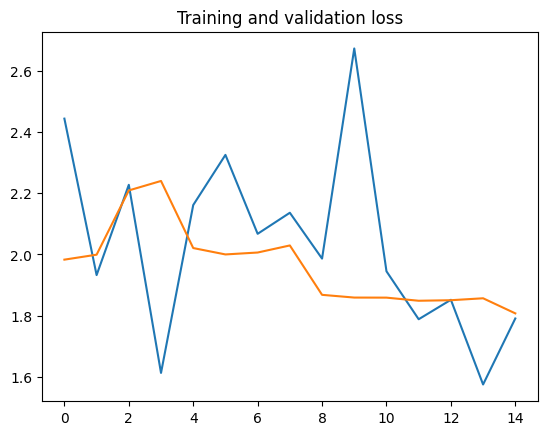

In [121]:
train_datagen = ImageDataGenerator(
    brightness_range=(0.6, 1.4),
    zoom_range=0.1,
    width_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='reflect',
    rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='File_Path',
        y_col='Labels',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')


history = model.fit(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=BATCH_SIZE * STEPS_PER_EPOCH,  # 1000 images = batch_size * steps
      verbose=1)

acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [122]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [123]:
pre_trained_model = tf.keras.applications.InceptionV3(weights='imagenet',
                                          include_top=False,
                                          input_shape=(150, 150, 3))

pre_trained_model2 = tf.keras.applications.InceptionV3(weights='imagenet',
                                          include_top=False,
                                          input_shape=(150, 150, 3))

In [124]:
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_391 (Conv2D) │ (None, 74, 74,    │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │         96 │ conv2d_391[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_376      │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_392 (Conv2D) │ (None, 72, 72,    │      9,216 │ activation_376[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_392[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_377      │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_393 (Conv2D) │ (None, 72, 72,    │     18,432 │ activation_377[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_393[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_378      │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 35, 35,    │          0 │ activation_378[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_394 (Conv2D) │ (None, 35, 35,    │      5,120 │ max_pooling2d_31… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_394[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_379      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_395 (Conv2D) │ (None, 33, 33,    │    138,240 │ activation_379[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_395[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_380      │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [125]:
for layer in pre_trained_model.layers:
  layer.trainable = False

# заморожуємо вагові коефіцієнти завантаженої моделі, крім останніх 10 шарів
for layer in pre_trained_model2.layers[-10:]:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_layer2 = pre_trained_model2.get_layer('mixed7')

print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output
last_output2 = last_layer2.output

last layer output shape:  (None, 7, 7, 768)


In [126]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense  (11, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = get_optimizer(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

Epoch 1/20

Epoch 1: saving model to training/default/checkpoint.weights.h5
274/274 - 90s - 327ms/step - accuracy: 0.7288 - loss: 0.8136 - val_accuracy: 0.8245 - val_loss: 0.5108
Epoch 2/20

Epoch 2: saving model to training/default/checkpoint.weights.h5
274/274 - 18s - 65ms/step - accuracy: 0.8500 - loss: 0.4438 - val_accuracy: 0.8157 - val_loss: 0.5293
Epoch 3/20

Epoch 3: saving model to training/default/checkpoint.weights.h5
274/274 - 69s - 251ms/step - accuracy: 0.8504 - loss: 0.4449 - val_accuracy: 0.8296 - val_loss: 0.5237


Text(0.5, 1.0, 'Training and validation loss')

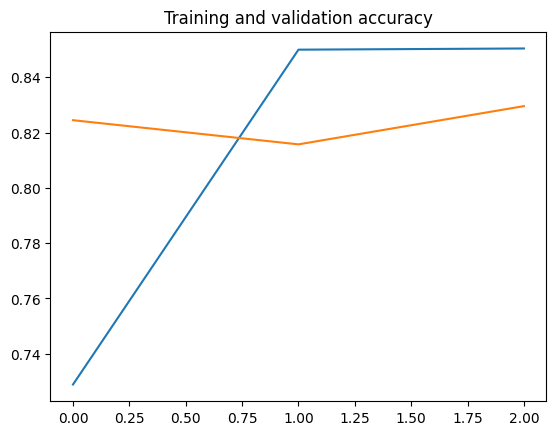

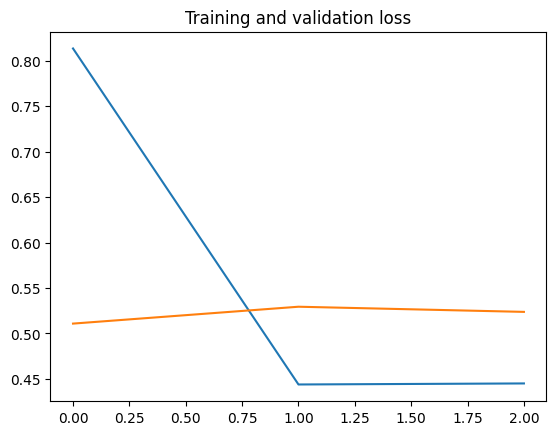

In [127]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = STEPS_PER_EPOCH,
            epochs = 20,
            validation_steps = BATCH_SIZE * STEPS_PER_EPOCH,
            verbose = 2,
            callbacks = get_callbacks())

acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [128]:
x = layers.Flatten()(last_output2)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense  (11, activation='softmax')(x)

model = Model(pre_trained_model2.input, x)

model.compile(optimizer = get_optimizer(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


Epoch 1/20

Epoch 1: saving model to training/default/checkpoint.weights.h5
274/274 - 156s - 570ms/step - accuracy: 0.7541 - loss: 0.7398 - val_accuracy: 0.8376 - val_loss: 0.5431
Epoch 2/20

Epoch 2: saving model to training/default/checkpoint.weights.h5
274/274 - 18s - 67ms/step - accuracy: 0.8500 - loss: 0.5627 - val_accuracy: 0.8339 - val_loss: 0.5482
Epoch 3/20

Epoch 3: saving model to training/default/checkpoint.weights.h5
274/274 - 78s - 284ms/step - accuracy: 0.8806 - loss: 0.3658 - val_accuracy: 0.8602 - val_loss: 0.4246
Epoch 4/20

Epoch 4: saving model to training/default/checkpoint.weights.h5
274/274 - 24s - 89ms/step - accuracy: 0.8500 - loss: 0.5649 - val_accuracy: 0.8653 - val_loss: 0.4088
Epoch 5/20

Epoch 5: saving model to training/default/checkpoint.weights.h5
274/274 - 106s - 388ms/step - accuracy: 0.9157 - loss: 0.2480 - val_accuracy: 0.8456 - val_loss: 0.5338
Epoch 6/20

Epoch 6: saving model to training/default/checkpoint.weights.h5
274/274 - 17s - 61ms/step - a

Text(0.5, 1.0, 'Training and validation loss')

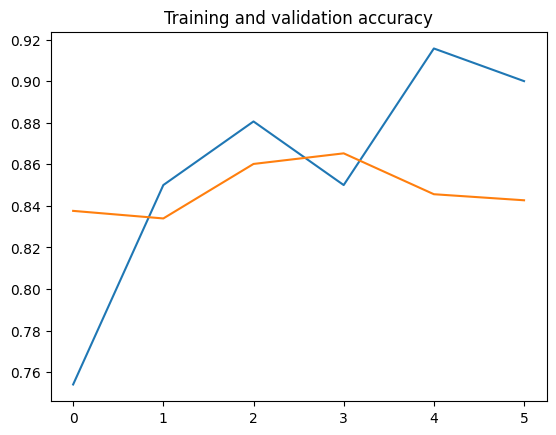

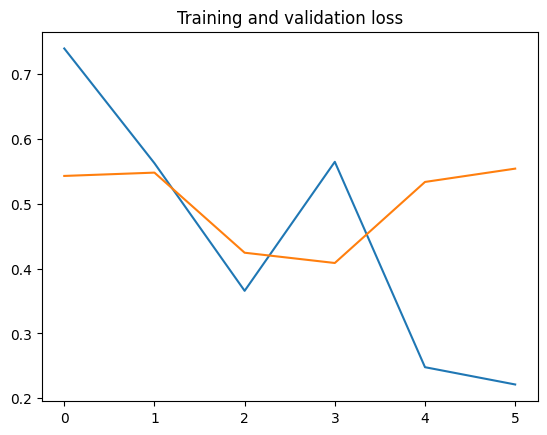

In [129]:
 history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = STEPS_PER_EPOCH,
            epochs = 20,
            validation_steps = BATCH_SIZE * STEPS_PER_EPOCH,
            verbose = 2,
            callbacks = get_callbacks())

acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [152]:
pre_trained_model = tf.keras.applications.InceptionV3(weights='imagenet',
                                          include_top=False,
                                          input_shape=(150, 150, 3))

for layer in pre_trained_model.layers[-10:]:
  layer.trainable = False



x = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(pre_trained_model.output)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(11, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = get_optimizer(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

Epoch 1/20

Epoch 1: saving model to training/default/checkpoint.weights.h5
274/274 - 67s - 245ms/step - accuracy: 0.8298 - loss: 0.8553 - val_accuracy: 0.8616 - val_loss: 0.7400
Epoch 2/20

Epoch 2: saving model to training/default/checkpoint.weights.h5
274/274 - 12s - 43ms/step - accuracy: 0.8500 - loss: 0.6196 - val_accuracy: 0.8616 - val_loss: 0.7408
Epoch 3/20

Epoch 3: saving model to training/default/checkpoint.weights.h5
274/274 - 68s - 247ms/step - accuracy: 0.8585 - loss: 0.7435 - val_accuracy: 0.8704 - val_loss: 0.7431


Text(0.5, 1.0, 'Training and validation loss')

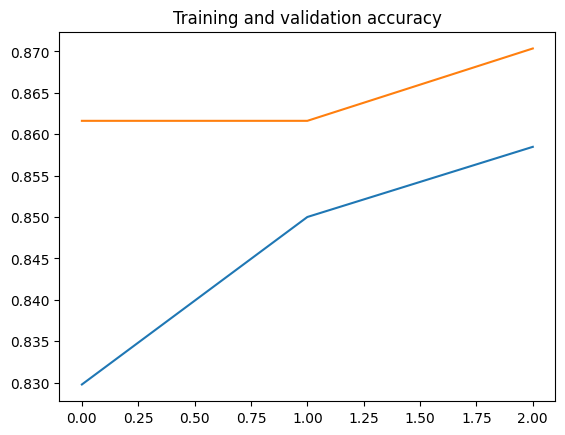

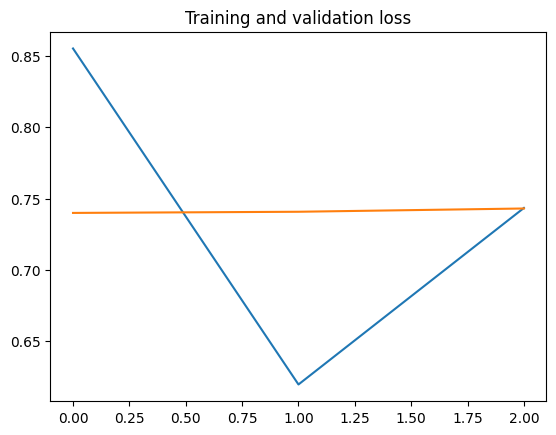

In [154]:
 history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = STEPS_PER_EPOCH,
            epochs = 20,
            validation_steps = BATCH_SIZE * STEPS_PER_EPOCH,
            verbose = 2,
            callbacks = get_callbacks())

acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [163]:
initial_learning_rate = 0.001
decay_steps = STEPS_PER_EPOCH * 50
decay_rate = 0.96
staircase = False

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=staircase
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [164]:
import os

def get_callbacks(name = "default"):
  checkpoint_path = "training/" + name + "/checkpoint.weights.h5"

  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)
  return [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min'), cp_callback]

In [165]:
pre_trained_model = tf.keras.applications.InceptionV3(weights='imagenet',
                                          include_top=False,
                                          input_shape=(150, 150, 3))

for layer in pre_trained_model.layers[-10:]:
  layer.trainable = False



x = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(pre_trained_model.output)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(11, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = get_optimizer(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

Epoch 1/20

Epoch 1: saving model to training/default/checkpoint.weights.h5
274/274 - 200s - 730ms/step - accuracy: 0.4931 - loss: 1.9407 - val_accuracy: 0.3787 - val_loss: 82.5720
Epoch 2/20

Epoch 2: saving model to training/default/checkpoint.weights.h5
274/274 - 30s - 110ms/step - accuracy: 0.5000 - loss: 1.8847 - val_accuracy: 0.4020 - val_loss: 98.4273
Epoch 3/20

Epoch 3: saving model to training/default/checkpoint.weights.h5
274/274 - 105s - 385ms/step - accuracy: 0.6027 - loss: 1.5513 - val_accuracy: 0.6431 - val_loss: 1.4432
Epoch 4/20

Epoch 4: saving model to training/default/checkpoint.weights.h5
274/274 - 27s - 98ms/step - accuracy: 0.5000 - loss: 1.5544 - val_accuracy: 0.6599 - val_loss: 1.3627
Epoch 5/20

Epoch 5: saving model to training/default/checkpoint.weights.h5
274/274 - 98s - 358ms/step - accuracy: 0.6674 - loss: 1.3114 - val_accuracy: 0.5229 - val_loss: 2.0286
Epoch 6/20

Epoch 6: saving model to training/default/checkpoint.weights.h5
274/274 - 27s - 97ms/step 

Text(0.5, 1.0, 'Training and validation loss')

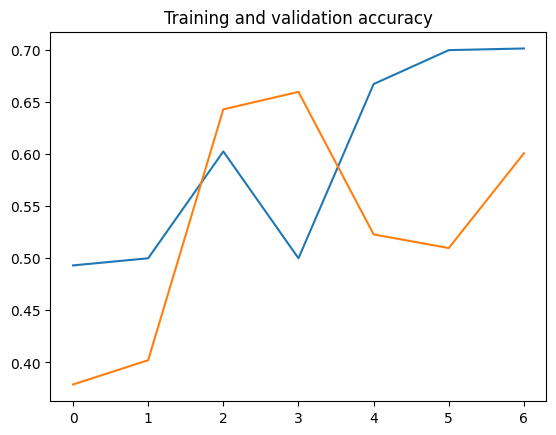

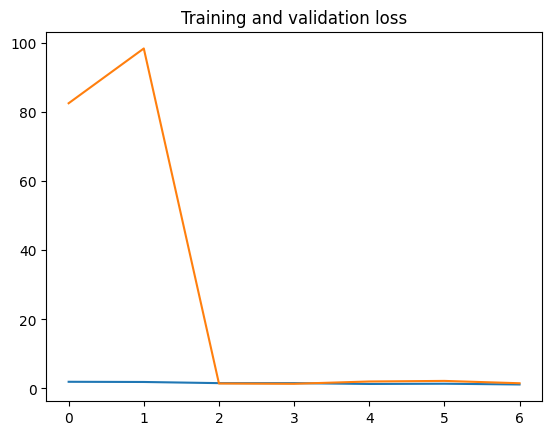

In [166]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = STEPS_PER_EPOCH,
            epochs = 20,
            validation_steps = BATCH_SIZE * STEPS_PER_EPOCH,
            verbose = 2,
            callbacks = get_callbacks())

acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )